# 模型选择 + 过拟合和欠拟合

>通过多项式拟合来交互探索

In [187]:
import math
import numpy as np
import torch
from torch import nn, optim
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [188]:
# 最大拟合项
max_degree = 20
# 训练样本规模
n_train, n_test = 30, 30
# 设定真实的权重
true_w = torch.zeros(max_degree)
# true_w[:4] = torch.Tensor([5, 1.2, -3.4, 5.6]) / torch.FloatTensor([1, 2, 6, 24])
true_w[:4] = torch.Tensor([5, 0, 0, 0]) / torch.FloatTensor([1, 2, 6, 24])

true_b = .2

In [189]:
true_w

tensor([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [190]:
features = torch.rand(size=(n_train + n_test, 1)) - 0.5  # 生成原始的特征
features, _ = features.sort(dim=0)
features[::10]

tensor([[-0.4916],
        [-0.2542],
        [-0.0914],
        [ 0.0247],
        [ 0.1744],
        [ 0.3087]])

In [191]:
# 特征工程: 生成多项式项
poly_features = features ** torch.arange(1, max_degree+1)

In [192]:
# 产生标签数据
labels = torch.matmul(poly_features, true_w) + true_b
y = labels.clone()
labels += np.random.normal(scale=0.1, size=labels.shape).astype(dtype=np.float32)

### 可视化原始数据

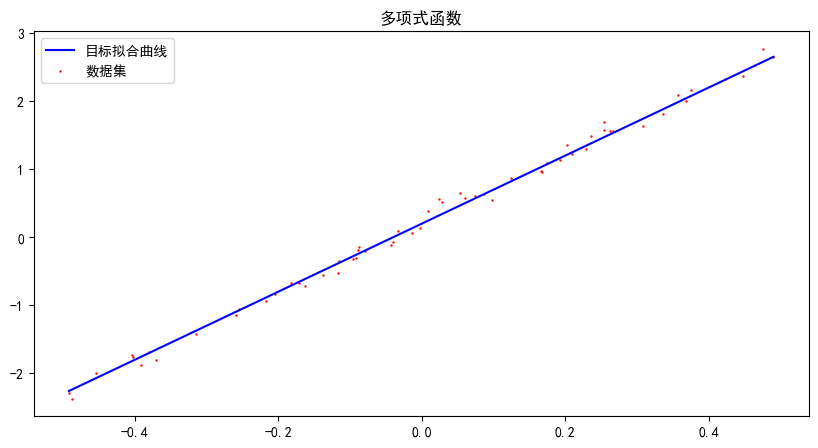

In [193]:
plt.figure(figsize=(10, 5))
plt.title("多项式函数")
plt.plot(features, y, c='b', label='目标拟合曲线')
plt.scatter(features, labels, s=0.5, c='r', label='数据集')
plt.legend()
plt.show()

### 定义神经网络

> 实现一个函数来评估模型在给定数据集上的损失 

In [194]:
def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=0.01)
            nn.init.zeros_(m.bias)  

def train_polynomial_regression(features, labels, degree, num_epochs, learning_rate, vaild_feaures, vaild_labels):
    # Initialize the model, loss function, and optimizer
    model = nn.Linear(degree, 1)
    # 初始化参数
    model.apply(init_normal)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # 训练loss
    train_loss_list = []
    vaild_loss_list = []
    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_loss_list.append(loss.item())
        with torch.no_grad():
            y_vaild = model(vaild_feaures)
            vaild_loss = criterion(y_vaild, vaild_labels)
            vaild_loss_list.append(vaild_loss.item())
    
    return model, train_loss_list, vaild_loss_list


In [195]:
# Parameters
num_epochs = 1000
learning_rate = 0.1

# 随机选择 100 个作为训练集(下标采样)
train_index = np.random.choice(np.arange(0, n_train + n_test), n_train, replace=False)
test_index = np.array([i for i in np.arange(n_test + n_test) if i not in train_index])
train_index = np.sort(train_index)

In [196]:
vaild_y = labels[test_index].reshape(-1)
train_y = labels[train_index]
vaild_x = features[test_index].reshape(-1)
train_x = features[train_index].reshape(-1)

In [197]:
# 拟合项
def overfitting_show(features, poly_features, labels, degrees, num_epochs, learning_rate):
    """
    :param poly_feateures: 多项式特征
    :param labels: 标签
    :param degress: 特征阶数
    ...
    """
    test_labels = labels[test_index].reshape(-1)
    train_labels = labels[train_index]
    hats = {}
    for degree in degrees:
        train_features = poly_features[train_index,:degree]
        test_features = poly_features[test_index,:degree]
        # Train the model
        model, train_loss, vaild_loss = train_polynomial_regression(train_features, train_labels, degree, num_epochs, learning_rate, test_features, test_labels)

        # Test the model
        hats[degree] = dict(
            train_loss=train_loss,
            vaild_loss=vaild_loss,
            model=model,
        )
    
    return hats

In [198]:
degrees = [1, ]
# degrees = [1, 3, 4, 10, 15]

In [199]:
hats = overfitting_show(
    features.clone(), 
    poly_features.clone(), 
    labels.clone(),
    degrees,
    num_epochs,
    learning_rate
    )

(60,) torch.Size([60])


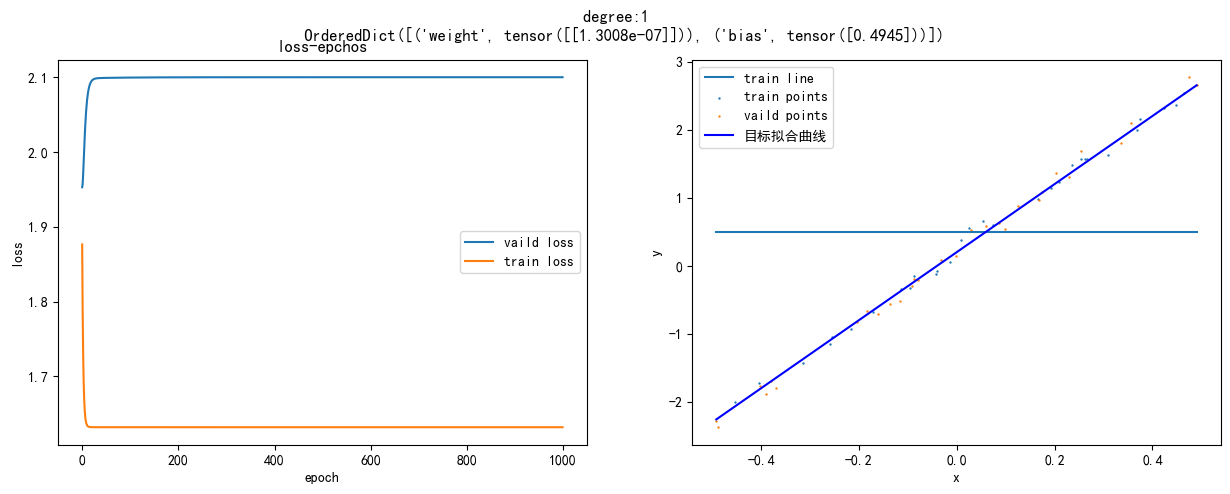

In [200]:
for degree, hat in hats.items():
    vaild_loss = hat['vaild_loss']
    train_loss = hat['train_loss']
    model = hat['model']
    y_all_hat = model(poly_features[:, :degree]).reshape(-1).detach().numpy()
    print(y_all_hat.shape, features.reshape(-1).shape)
    x = np.arange(len(vaild_loss))
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"degree:{degree} \n {model.state_dict()}")
    axs[0].set_title("loss-epchos")
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].plot(x, vaild_loss, label='vaild loss')
    axs[0].plot(x, train_loss, label='train loss')
    axs[1].plot(features.reshape(-1).detach().numpy(), y_all_hat, label='train line')
    axs[1].scatter(train_x, train_y, s=0.5, label='train points')
    axs[1].scatter(vaild_x, vaild_y, s=0.5, label='vaild points')
    plt.plot(features, y, c='b', label='目标拟合曲线')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    for ax in axs:
        ax.legend()
    plt.show()